In [48]:
import torch

import pandas             as pd
import numpy              as np
import pylab              as pl

from sklearn.metrics import f1_score

from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [49]:
params = {'legend.fontsize': '20',
          'figure.figsize': (7, 7),
         'axes.labelsize': '20',
         'axes.titlesize':'20',
         'xtick.labelsize':'20',
         'ytick.labelsize':'20'}
pl.rcParams.update(params)

In [50]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 64)
        self.conv2 = GCNConv(64, data.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [51]:
classes = ['Void','Sheet','Filament','Peak']

df = pd.read_pickle('./data/TCW_topological_dataset_50.pkl')
idx = np.arange(len(df))
df.keys(), len(idx)

(Index(['ID', 'X', 'Y', 'Z', 'MASS', 'ENVIRONMENT', 'ID_DELAUNAY_CONNECTIONS',
        'N_DELAUNAY_CONNECTIONS', 'DIS_DELAUNAY_CONNECTIONS',
        'AVDIS_DELAUNAY_CONNECTIONS', 'ID_DELAUNAY_FIRSTNEIGH_CONNECTIONS',
        'N_DELAUNAY_FIRSTNEIGH_CONNECTIONS', 'ID_BSK_CONNECTIONS',
        'N_BSK_CONNECTIONS', 'DIS_BSK_CONNECTIONS', 'AVDIS_BSK_CONNECTIONS',
        'ID_BSK_FIRSTNEIGH_CONNECTIONS', 'N_BSK_FIRSTNEIGH_CONNECTIONS'],
       dtype='object'),
 5694)

## Delaunay + Bsk Features  || Delaunay Edges -> TWebEnv

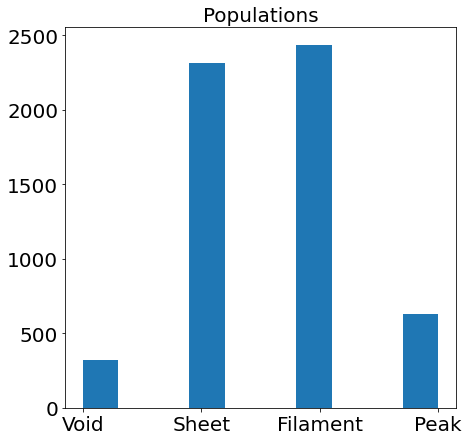

(2431, array([ 5.58482613, 40.6743941 , 42.69406393, 11.04671584]))

In [52]:
envs, populations = np.unique(df['ENVIRONMENT'], return_counts=True)

_ = pl.hist(df['ENVIRONMENT'])
pl.xticks(envs, classes)
pl.title('Populations')
pl.show()


Max_pop = max(populations)
Max_pop, populations/sum(populations)*100

In [73]:
idx_void_new = np.random.choice(idx[np.array(df['ENVIRONMENT'])==0], populations[2] - populations[0] , replace=True)
idx_sheet_new = np.random.choice(idx[np.array(df['ENVIRONMENT'])==1], populations[2] - populations[1], replace=True)
idx_fila_new = np.random.choice(idx[np.array(df['ENVIRONMENT'])==2], populations[2] - populations[2], replace=True)
idx_peak_new = np.random.choice(idx[np.array(df['ENVIRONMENT'])==3], populations[2] - populations[3], replace=True)

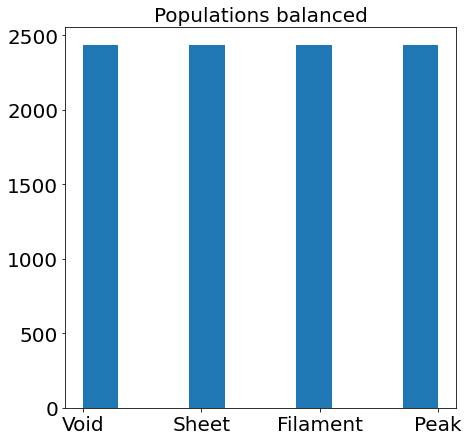

In [75]:
env_balanced_pop = np.concatenate([df['ENVIRONMENT'],
                                   df['ENVIRONMENT'][idx_void_new],
                                   df['ENVIRONMENT'][idx_sheet_new],
                                   df['ENVIRONMENT'][idx_fila_new],
                                   df['ENVIRONMENT'][idx_peak_new]
                                  ])
pl.xticks(envs, classes)
pl.title('Populations balanced')
_ = pl.hist(env_balanced_pop)

In [89]:
predictors = np.array(df[['N_DELAUNAY_CONNECTIONS','AVDIS_DELAUNAY_CONNECTIONS',
                          'N_BSK_CONNECTIONS','AVDIS_BSK_CONNECTIONS']], dtype=float)
predictors = np.concatenate([predictors,
                             predictors[idx_void_new],
                             predictors[idx_sheet_new],
                             predictors[idx_fila_new],
                             predictors[idx_peak_new]
                            ])
x = torch.tensor(predictors, dtype=torch.float)  #features

connections = df['ID_DELAUNAY_CONNECTIONS']
connections = np.concatenate([connections,
                              connections[idx_void_new],
                              connections[idx_sheet_new],
                              connections[idx_fila_new],
                              connections[idx_peak_new]
                             ])                              

A = []
for i, c in enumerate(connections):
    if (i < len(df)):  
        A.append(np.zeros(len(c))+i)
    elif (i >= len(df)) & (i < len(df)+len(idx_void_new)):
        j = i-len(df)
        A.append(np.zeros(len(c))+idx_void_new[j])
    elif (i >= len(df)+len(idx_void_new)) & (i < len(df)+len(idx_void_new)+len(idx_sheet_new)):
        j = i-len(df)-len(idx_void_new)
        A.append(np.zeros(len(c))+idx_sheet_new[j])
    elif (i >= len(df)+len(idx_void_new)+len(idx_sheet_new)) & (i < len(df)+len(idx_void_new)+len(idx_sheet_new)+len(idx_fila_new)):
        j = i-len(df)-len(idx_void_new) -len(idx_fila_new)
        A.append(np.zeros(len(c))+idx_fila_new[j])
    elif (i >= len(df)+len(idx_void_new)+len(idx_sheet_new)+len(idx_fila_new)) & (i < len(df)+len(idx_void_new)+len(idx_sheet_new)+len(idx_fila_new)+len(idx_peak_new)): 
        j = i-len(df)-len(idx_void_new)-len(idx_fila_new)-len(idx_sheet_new)
        A.append(np.zeros(len(c))+idx_peak_new[j])        
        
A = np.concatenate(A).ravel()
B = np.concatenate([ c for c in connections]).ravel()

edge_index = torch.tensor([A,B], dtype=torch.long) # Conecctions

target = np.array([ c for c in  df['ENVIRONMENT'] ])
target = np.concatenate([target, 
                         target[idx_void_new],
                         target[idx_sheet_new],
                         target[idx_fila_new],
                         target[idx_peak_new]
                        ])

y = torch.tensor(target, dtype=torch.long)  #target

/tmp/ipykernel_158511/3430488703.py:39: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  edge_index = torch.tensor([A,B], dtype=torch.long) # Conecctions


In [90]:
_, balanced_pop =  np.unique(target, return_counts=True)
balanced_pop/sum(balanced_pop)*100

array([25., 25., 25., 25.])

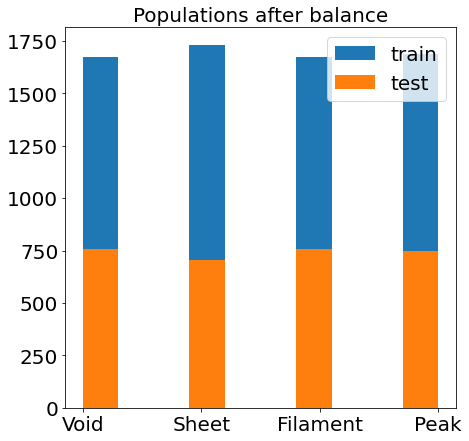

In [91]:
data = Data(x=x, edge_index=edge_index, y=y, num_classes= len(np.unique(y)))

perm = np.random.rand(len(target))
ii_train = perm>0.3
train_mask = ii_train
test_mask  = ~ii_train

data.train_mask = torch.tensor(train_mask, dtype=torch.bool)
data.test_mask = torch.tensor(test_mask, dtype=torch.bool)

_ = pl.hist(target[train_mask], label='train')
_ = pl.hist(target[test_mask], label='test')
pl.xticks(envs, classes)
pl.title('Populations after balance')
pl.legend()
pl.show()

cuda
Accuracy: 0.7302
f1_score: 0.7294


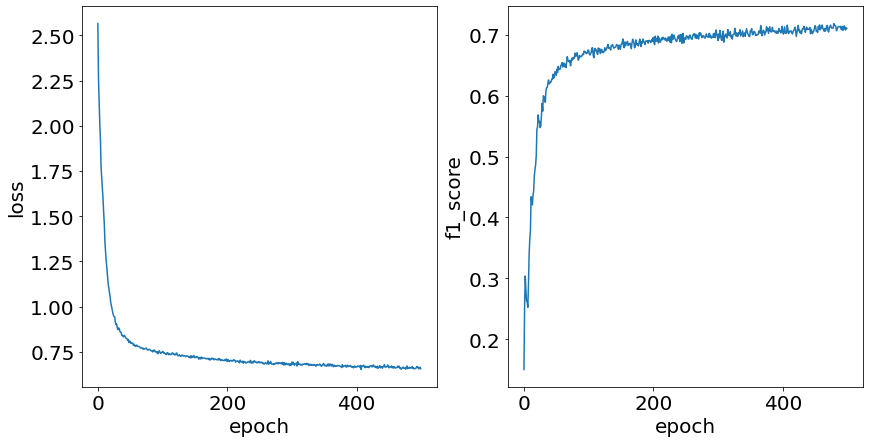

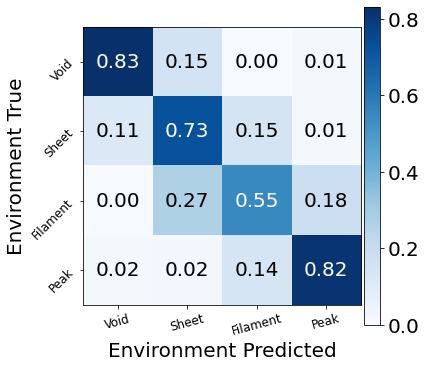

In [92]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# device = 'cpu'
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
lloss = []
lf1   = []

model.train()
for epoch in range(500):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    lloss.append(loss.cpu().data)
    f1 = f1_score(data.y[data.train_mask].cpu().detach().numpy(), out[data.train_mask].cpu().argmax(dim=1).detach().numpy(), average='weighted')
    lf1.append(f1)
    loss.backward()
    optimizer.step()
    
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')    

f1 = f1_score(data.y[data.test_mask].cpu().data, pred[data.test_mask].cpu(), average='weighted')
print(f'f1_score: {f1:.4f}')

fig = pl.figure(figsize=(14,7))
pl.subplot(1,2,1)
_ = pl.plot(lloss)
pl.xlabel('epoch')
pl.ylabel('loss')
pl.subplot(1,2,2)
_ = pl.plot(lf1)
pl.xlabel('epoch')
pl.ylabel('f1_score')

#------------ Confusion Matrix
cm = confusion_matrix(np.array(data.y[data.test_mask].cpu().data), np.array(pred[data.test_mask].cpu().data))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig= pl.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
im = ax.imshow(cm, interpolation='nearest', cmap=pl.cm.Blues)
ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.79)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes)
ax.set_xlabel("Environment Predicted",size=20)
ax.set_ylabel("Environment True",size=20)
# ax.set_ylim(4-0.5, -0.5)

pl.setp(ax.get_xticklabels(), rotation=15, size=12)
pl.setp(ax.get_yticklabels(), rotation=45, size=12)

fmt = '.2f'
thresh = cm.max()/2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=20 , color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
pl.tight_layout()
pl.show()